In [6]:
import openmc 
import openmc.deplete

%matplotlib inline
import numpy as np

### Model materials


In [7]:
# materials
fuel = openmc.Material(name="uo2")
fuel.add_element("U",1.0, percent_type="ao",enrichment=5.0)
fuel.add_element("O",2.0)
fuel.set_density("g/cc",10.45)

clad = openmc.Material(name="clad")
clad.add_element("Zr",0.981858,percent_type="wo");
clad.add_element("O",0.001196,percent_type="wo");
clad.add_element("Cr",9.97e-4,percent_type="wo");
clad.add_element("Fe",1.994e-3,percent_type="wo");
clad.add_element("Sn",1.3955e-2,percent_type="wo");
clad.set_density("g/cc",6.56)

gas = openmc.Material(name="gas")
gas.add_element("He",1.0,percent_type="ao");
gas.set_density("g/cc",1.47e-2);

blanket = openmc.Material(name="blanket")
blanket.add_element("U",1.0,percent_type="ao");
blanket.set_density("g/cc",18.95);

water = openmc.Material(name="water");
water.add_element("O",1);
water.add_element("H",2);
water.set_density("g/cc",0.712);
water.add_s_alpha_beta('c_H_in_H2O');

materials = openmc.Materials([fuel,clad,gas,blanket,water]);
materials.export_to_xml();


### Model parameters

In [8]:
h_fuel = 100. # cm
h_core = 150. # cm
r_core = 60. # cm
P_D = 1.3     # pitch/diameter ratio
N_assy = 9; # number of pins per dimension in the assembly, i.e. N_assy x N_assy 

r_fo = 0.4096 # cm, fuel outer radius
r_ci = 0.4179 # cm, clad inner radius
r_co = 0.4751 # cm, clad outer radius

pitch = r_co*2.*P_D; # cm, pin pitch
a_pitch = N_assy*pitch

N_core = 7; # number of assemblies per dimension in the core
c_pitch = N_core*a_pitch

### Surfaces

In [9]:
# pin boundaries
c_fo = openmc.ZCylinder(r=r_fo); # cylinder, fuel outer
c_ci = openmc.ZCylinder(r=r_ci); # cylinder, clad inner
c_co = openmc.ZCylinder(r=r_co); # cylinder, clad outer
c_t = openmc.ZPlane(z0=h_fuel/2.); # top of fuel pin
c_b = openmc.ZPlane(z0=-h_fuel/2.); # bottom of fuel pin

# assembly boundary
assy_bdy = openmc.model.RectangularParallelepiped(-a_pitch/2.,a_pitch/2.,
                                                  -a_pitch/2.,a_pitch/2.,
                                                  -h_fuel/2.,h_fuel/2.);

# core boundary
core_bdy = openmc.model.RectangularParallelepiped(-c_pitch/2.,c_pitch/2.,
                                                  -c_pitch/2.,c_pitch/2.,
                                                  -h_fuel/2.,h_fuel/2.);

# reactor pressure vessel boundary
rpv_bdy = openmc.model.RightCircularCylinder([0.,0.,-h_core/2.],
                                              h_core,r_core,
                                              boundary_type = 'vacuum');

In [10]:
# fuel pellet
fuel_cell = openmc.Cell()
fuel_cell.region = -c_fo & +c_b & -c_t
fuel_cell.fill = fuel;

# gap
gap_cell = openmc.Cell();
gap_cell.region = +c_fo & -c_ci & +c_b & -c_t;
gap_cell.fill = gas;

# bgap
bgap_cell = openmc.Cell();
bgap_cell.region = +c_fo & -c_ci & +c_b & -c_t;
bgap_cell.fill = gas;


# clad
clad_cell = openmc.Cell();
clad_cell.fill = clad;
clad_cell.region = +c_ci & -c_co & +c_b & -c_t;

#bclad
bclad_cell = openmc.Cell();
bclad_cell.fill = clad;
bclad_cell.region = +c_ci & -c_co & +c_b & -c_t;


# coolant outside the pin
coolant_cell = openmc.Cell();
coolant_cell.fill = water
coolant_cell.region = +c_co & +c_b & -c_t # note: infinite in extent

bcool_cell = openmc.Cell();
bcool_cell.fill = water;
bcool_cell.region = +c_co & +c_b & -c_t

# to be used as exterior cell for core lattices
water_cell = openmc.Cell();
#water_cell.region = -rpv_bdy 
water_cell.fill = water;  

all_water = openmc.Universe()
all_water.add_cell(water_cell);


In [11]:
pin_outer = openmc.Cell();
pin_outer.fill = water
pin_outer.region = +core_bdy & -rpv_bdy

fpc = openmc.Universe();
fpc.add_cells([fuel_cell,gap_cell,clad_cell,coolant_cell])


# lattice of seed fuel pins
SL = openmc.RectLattice();
SL.center = (0.,0.);
SL.dimension = [N_assy,N_assy];
SL.lower_left = [-N_assy/2.*pitch,-N_assy/2.*pitch]
SL.pitch = [pitch,pitch]
SL.universes = [
    [fpc,fpc,fpc,fpc,fpc,fpc,fpc,fpc,fpc],
    [fpc,fpc,fpc,fpc,fpc,fpc,fpc,fpc,fpc],
    [fpc,fpc,fpc,fpc,fpc,fpc,fpc,fpc,fpc],
    [fpc,fpc,fpc,fpc,fpc,fpc,fpc,fpc,fpc],
    [fpc,fpc,fpc,fpc,fpc,fpc,fpc,fpc,fpc],
    [fpc,fpc,fpc,fpc,fpc,fpc,fpc,fpc,fpc],
    [fpc,fpc,fpc,fpc,fpc,fpc,fpc,fpc,fpc],
    [fpc,fpc,fpc,fpc,fpc,fpc,fpc,fpc,fpc],
    [fpc,fpc,fpc,fpc,fpc,fpc,fpc,fpc,fpc]
]
SL.outer = all_water;

# universe corresponding to a seed assembly
S = openmc.Universe();
seed_cell = openmc.Cell();
seed_cell.fill = SL;
seed_cell.region = -assy_bdy
S.add_cell(seed_cell);






In [12]:
blanket_cell = openmc.Cell();
blanket_cell.fill = blanket
blanket_cell.region = -c_fo & +c_b & -c_t

bpc = openmc.Universe();
bpc.add_cells([blanket_cell,bgap_cell,bclad_cell,
              bcool_cell]);

# blanket lattice
BL = openmc.RectLattice();
BL.dimension = [N_assy,N_assy];
BL.lower_left = [-N_assy/2.*pitch,-N_assy/2.*pitch]
BL.pitch = [pitch,pitch];
BL.universes = [
    [bpc,bpc,bpc,bpc,bpc,bpc,bpc,bpc,bpc],
    [bpc,bpc,bpc,bpc,bpc,bpc,bpc,bpc,bpc],
    [bpc,bpc,bpc,bpc,bpc,bpc,bpc,bpc,bpc],
    [bpc,bpc,bpc,bpc,bpc,bpc,bpc,bpc,bpc],
    [bpc,bpc,bpc,bpc,bpc,bpc,bpc,bpc,bpc],
    [bpc,bpc,bpc,bpc,bpc,bpc,bpc,bpc,bpc],
    [bpc,bpc,bpc,bpc,bpc,bpc,bpc,bpc,bpc],
    [bpc,bpc,bpc,bpc,bpc,bpc,bpc,bpc,bpc],
    [bpc,bpc,bpc,bpc,bpc,bpc,bpc,bpc,bpc]    
]
BL.outer = all_water;

# universe corresponding to a blanket assembly
B = openmc.Universe();
blanket_cell = openmc.Cell();
blanket_cell.region = -assy_bdy;
blanket_cell.fill = BL;
B.add_cell(blanket_cell);



In [13]:
# water lattice
WL = openmc.RectLattice();
WL.dimension = [N_assy,N_assy];
WL.lower_left = [-N_assy/2.*pitch,-N_assy/2.*pitch]
WL.pitch = [pitch,pitch];
WL.universes = [
    [all_water]*9,
    [all_water]*9,
    [all_water]*9,
    [all_water]*9,
    [all_water]*9,
    [all_water]*9,
    [all_water]*9,
    [all_water]*9,
    [all_water]*9    
]
WL.outer = all_water;

W = openmc.Universe();
water_cell = openmc.Cell();
water_cell.region = -assy_bdy;
water_cell.fill = WL;
W.add_cell(water_cell);

In [14]:
# core lattice
CL = openmc.RectLattice();
CL.dimension = [N_core,N_core];
CL.lower_left = [-c_pitch/2.,-c_pitch/2.]
CL.pitch = [a_pitch,a_pitch];
CL.universes = [
    [W,B,B,B,B,B,W],
    [B,B,S,S,S,B,B],
    [B,S,S,S,S,S,B],
    [B,S,S,S,S,S,B],
    [B,S,S,S,S,S,B],
    [B,B,S,S,S,B,B],
    [W,B,B,B,B,B,W]  
    
]
CL.outer = all_water;

C = openmc.Universe();
core_cell = openmc.Cell();
core_cell.region = -core_bdy;
core_cell.fill = CL;
C.add_cell(core_cell);


In [15]:
colors = {}
colors[water]='blue';
colors[fuel]='yellow';
colors[clad]='gray';
colors[gas]='red';
colors[blanket]='green';

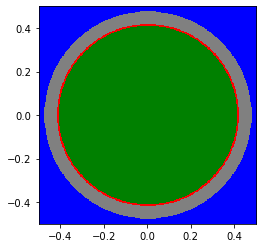

In [16]:
bpc.plot(width=(1,1),pixels=(400,400),color_by='material',colors=colors)

In [17]:
root_univ = openmc.Universe();

all_assy = openmc.Cell();
all_assy.region = -core_bdy
all_assy.fill = C

ref_cell = openmc.Cell();
ref_cell.region = +core_bdy & -rpv_bdy
ref_cell.fill = water

root_univ.add_cells([all_assy,ref_cell])



In [18]:


geometry = openmc.Geometry();
geometry.root_universe = root_univ;
geometry.export_to_xml();

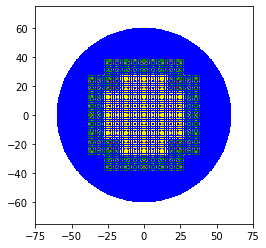

In [19]:
root_univ.plot(width=(150,150),pixels=(400,400),
               color_by='material',colors=colors)

In [20]:
settings = openmc.Settings();
settings.run_mode = 'eigenvalue';
settings.particles = 20000;
settings.batches = 200;
settings.inactive = 50;

box = openmc.stats.Box(lower_left=(-c_pitch/2.,-c_pitch/2.,-h_fuel/2.),
                      upper_right=(c_pitch/2.,c_pitch/2.,h_fuel/2.),
                      only_fissionable=True);

src = openmc.Source(space=box);
settings.source = src;

settings.export_to_xml();

In [21]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      110/1    1.13401    1.13380 +/- 0.00152
      111/1    1.13895    1.13388 +/- 0.00150
      112/1    1.12519    1.13374 +/- 0.00148
      113/1    1.12058    1.13353 +/- 0.00147
      114/1    1.12612    1.13342 +/- 0.00145
      115/1    1.12760    1.13333 +/- 0.00143
      116/1    1.12223    1.13316 +/- 0.00142
      117/1    1.13025    1.13312 +/- 0.00140
      118/1    1.13456    1.13314 +/- 0.00138
      119/1    1.11357    1.13285 +/- 0.00139
      120/1    1.13943    1.13295 +/- 0.00137
      121/1    1.12734    1.13287 +/- 0.00135
      122/1    1.14358    1.13302 +/- 0.00134
      123/1    1.14044    1.13312 +/- 0.00133
      124/1    1.13561    1.13315 +/- 0.00131
      125/1    1.13664    1.13320 +/- 0.00129
      126/1    1.13337    1.13320 +/- 0.00128
      127/1    1.16610    1.13363 +/- 0.00133
      128/1    1.12135    1.13347 +/- 0.00132
      129/1    1.14803    1.13366 +/- 0.00132
      130/1    1.13839    1.13372 +/- 0.00130
      131/1    1.14550    1.13386 